# Time series forecasting

## Objective

* Forecast traffic on JetRail for the next 7 months
* Unicorn Investors will only invest if there are more than 1 million monthly users within the next 18 months


## Hypothesis

* Traffic increases over the years. Population has an upward trend with time. Companies expand their business over time leading to more customers
* Traffic will be higher over May to October. Tourist visits increase during this time period
* Weekday traffic is more than weekends / holidays. People travel to work / college during the weekdays leading to higher traffic
* Traffic is higher during peak hours. This is when most people are travelling to work / college

In [76]:
# Core libraries
import pandas as pd 
from pandas import Series
import numpy as np         
from datetime import datetime   
        
# Data visualization
import matplotlib.pyplot as plt 
%matplotlib inline 

# Models
from statsmodels.tsa.api import ExponentialSmoothing, SimpleExpSmoothing, Holt 
import statsmodels.api as sm 

# Model metrics
from sklearn.metrics import mean_squared_error 
from math import sqrt 

# Suppress warnings
import warnings                   
warnings.filterwarnings("ignore")

## Functions

In [67]:
def plot_moving_average(y_hat_avg, window_size):
    # Plot train, validation and moving average results
    plt.figure(figsize=(15,5)) 
    plt.plot(train['Count'], label='Train') 
    plt.plot(valid['Count'], label='Valid') 
    plt.plot(y_hat_avg['moving_avg_forecast'], label=f"Moving Average Forecast using {window_size} observations")
    plt.legend(loc='best') 
    plt.show()


def calculate_moving_average(window_size):
    # Calculate moving average in time window
    y_hat_avg = valid.copy() 
    y_hat_avg['moving_avg_forecast'] = train['Count'].rolling(window_size).mean().iloc[-1] 
    return y_hat_avg

## Read data

* Data features:
  * ID. Unique number of each observation. Has zero feature importance and is removed
  * Datetime. Date and time of each observation
  * Count. Passenger count at each datetime

In [2]:
train = pd.read_csv("Train_SU63ISt.csv") 
test = pd.read_csv("Test_0qrQsBZ.csv")

In [3]:
# Drop the ID column
train.drop(columns=['ID'], inplace=True)
test.drop(columns=['ID'], inplace=True)

print(f"train dimensions {train.shape}")
print(f"test dimensions {test.shape}")

train dimensions (18288, 2)
test dimensions (5112, 1)


In [4]:
train.head()

,Datetime,Count
0,25-08-2012 00:00,8
1,25-08-2012 01:00,2
2,25-08-2012 02:00,6
3,25-08-2012 03:00,2
4,25-08-2012 04:00,2


In [5]:
test.head()

,Datetime
0,26-09-2014 00:00
1,26-09-2014 01:00
2,26-09-2014 02:00
3,26-09-2014 03:00
4,26-09-2014 04:00


## Feature extraction

* Datetime is a string. Convert to datetime format
* Extract the year, month, day and hour information from Datetime. We need this to check our date-based hypothesis
* Determine whether a date occurred on a weekend or weekday

In [6]:
# Datetime column  is of type 'object' i.e. a string
train.dtypes

Datetime    object
Count        int64
dtype: object

In [7]:
# Datetime column  is of type 'object' i.e. a string
test.dtypes

Datetime    object
dtype: object

In [8]:
# Convert Datetime column for both train and test sets from string to datetime format
train['Datetime'] = pd.to_datetime(train.Datetime, format='%d-%m-%Y %H:%M') 
test['Datetime'] = pd.to_datetime(test.Datetime, format='%d-%m-%Y %H:%M') 

In [9]:
for col in (train, test):
    col['year'] = col.Datetime.dt.year 
    col['month'] = col.Datetime.dt.month 
    col['day'] = col.Datetime.dt.day    
    col['hour'] = col.Datetime.dt.hour
    col['day of week'] = col.Datetime.dt.dayofweek

In [10]:
train.head()

,Datetime,Count,year,month,day,hour,day of week
0,2012-08-25 00:00:00,8,2012,8,25,0,5
1,2012-08-25 01:00:00,2,2012,8,25,1,5
2,2012-08-25 02:00:00,6,2012,8,25,2,5
3,2012-08-25 03:00:00,2,2012,8,25,3,5
4,2012-08-25 04:00:00,2,2012,8,25,4,5


In [11]:
test.head()

,Datetime,year,month,day,hour,day of week
0,2014-09-26 00:00:00,2014,9,26,0,4
1,2014-09-26 01:00:00,2014,9,26,1,4
2,2014-09-26 02:00:00,2014,9,26,2,4
3,2014-09-26 03:00:00,2014,9,26,3,4
4,2014-09-26 04:00:00,2014,9,26,4,4


In [12]:
# Convert Datetime to a weekday number, Saturday (5) Sunday (6)
train['weekend'] = train['Datetime'].dt.weekday >= 5

# Output is boolean (True, False). Convert to integer (1, 0)
train['weekend'] = train['weekend'].astype(int)

## Plot time series

In [13]:
# X-axis is Datetime
train.set_index('Datetime')

,Count,year,month,day,hour,day of week,weekend
Datetime,,,,,,,
2012-08-25 00:00:00,8,2012,8,25,0,5,1
2012-08-25 01:00:00,2,2012,8,25,1,5,1
2012-08-25 02:00:00,6,2012,8,25,2,5,1
2012-08-25 03:00:00,2,2012,8,25,3,5,1
2012-08-25 04:00:00,2,2012,8,25,4,5,1
...,...,...,...,...,...,...,...
2014-09-25 19:00:00,868,2014,9,25,19,3,0
2014-09-25 20:00:00,732,2014,9,25,20,3,0
2014-09-25 21:00:00,702,2014,9,25,21,3,0


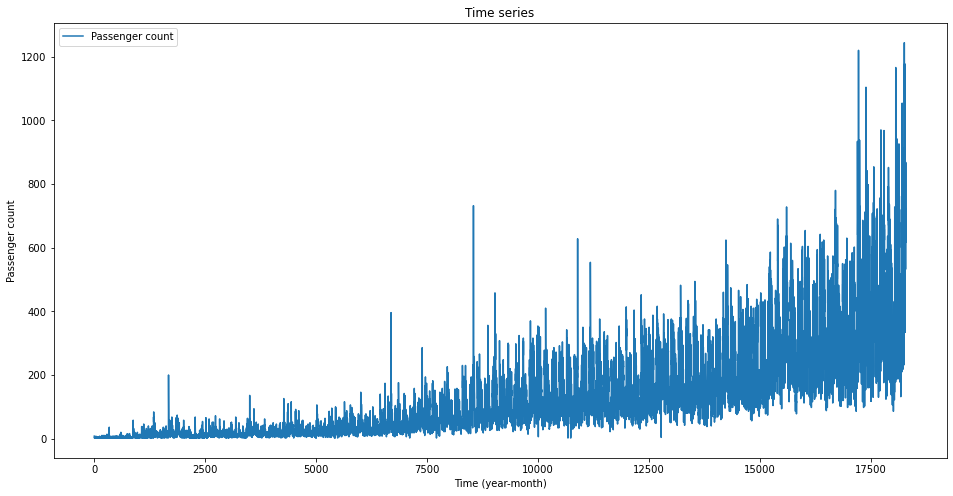

In [14]:
# Display time series
plt.figure(figsize=(16, 8))
plt.plot(train['Count'], label="Passenger count")
plt.title("Time series")
plt.xlabel("Time (year-month)")
plt.ylabel("Passenger count")
plt.legend(loc='best')
plt.show()

## Exploratory Data Analysis

### Hypothesis #1 

* Traffic increases over the years. Population has an upward trend with time. Companies expand their business over time leading to more customers
* We see an exponential growth in traffic
* Data supports our hypothesis

<AxesSubplot:xlabel='year'>

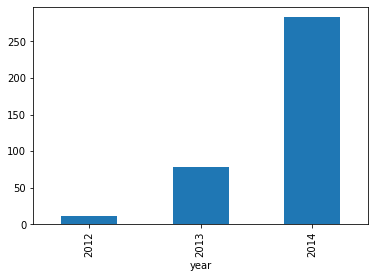

In [15]:
# Mean traffic by year
train.groupby('year')['Count'].mean().plot.bar()

### Hypothesis #2

* Traffic will be higher over May to October. Tourist visits increase during this time period
* The "Mean traffic by month" graph doesn't support our hypothesis
  * May to August shows growth in the mean traffic
  * September shows a decline in traffic
  * October, November and December are significantly lower than other months
* The "Mean traffic by year and month" graph shows that
  * Traffic levels in 2014 were significantly lower than the other years
  * 2012 has data for months 8 to 12 only
  * There is significant growth in traffic in 2013 and 2014
  * 2014 is missing data for months 10, 11, and 12
* Mean traffic appears to grow exponentially

<AxesSubplot:title={'center':'Mean traffic by month'}, xlabel='month'>

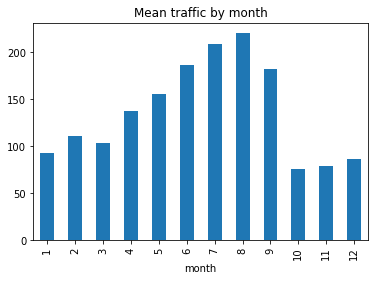

In [16]:
# Mean traffic by month
train.groupby('month')['Count'].mean().plot.bar(title='Mean traffic by month')

<AxesSubplot:title={'center':'Mean traffic by year and month'}, xlabel='year,month'>

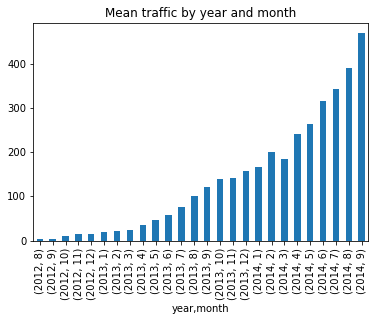

In [17]:
# Mean traffic by year and month
train.groupby(['year', 'month'])['Count'].mean().plot.bar(title='Mean traffic by year and month')

### Hypothesis #3

* Weekday traffic is more than weekends / holidays. People travel to work / college during the weekdays leading to higher traffic
* The "Mean traffic on weekdays (0) vs weekends (1)" graph shows that mean traffic on weekdays is greater than weekends
* The "Mean traffic by day of the week" shows the mean traffic by each day
  * 0 to 4 are Monday to Friday
  * 5 and 6 are Saturday and Sunday
  * There is a decrease of mean traffic over the weekend

<AxesSubplot:title={'center':'Mean traffic on weekdays (0) vs weekends (1)'}, xlabel='weekend'>

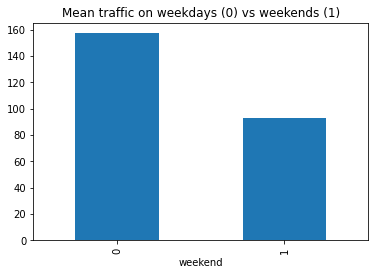

In [18]:
# Mean traffic on weekends vs weekdays
train.groupby('weekend')['Count'].mean().plot.bar(title='Mean traffic on weekdays (0) vs weekends (1)')

<AxesSubplot:title={'center':'Mean traffic by day of the week'}, xlabel='day of week'>

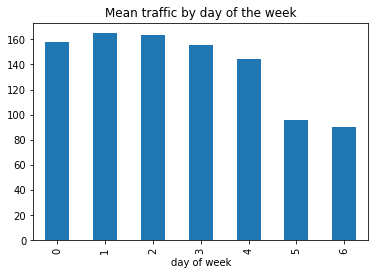

In [19]:
# Mean traffic by day of the week
train.groupby('day of week')['Count'].mean().plot.bar(title='Mean traffic by day of the week')

### Hypothesis #4

* Traffic is higher during peak hours. This is when most people are travelling to work / college
* The "Mean traffic by hour of the day" graph supports our hypothesis
  * Mean traffic is lowest in the early hours 
  * Mean traffic peaks at 7pm

<AxesSubplot:title={'center':'Mean traffic by hour of the day'}, xlabel='hour'>

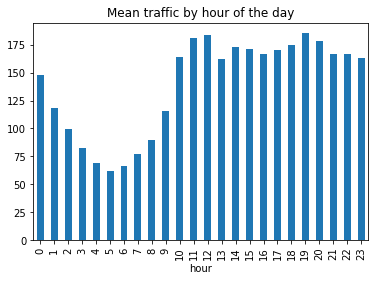

In [20]:
# Mean traffic by hour of the day
train.groupby('hour')['Count'].mean().plot.bar(title='Mean traffic by hour of the day')

## Prepare time series data

* Sample our data at hourly, daily, weekly, and monthly time intervals
* Hourly is the most noisy, would be difficult to train a model
* We want to make horly predictions so although the weekly and monthly trends are smoother and easier for the model to learn from, there is a lot of overhead converting predictions back to hourly
* Instead work with daily data for model building and convert to hourly predictions

In [21]:
train.Timestamp = pd.to_datetime(train.Datetime,format='%d-%m-%Y %H:%M') 
train.index = train.Timestamp 

hourly = train.resample('H').mean() 
daily = train.resample('D').mean() 
weekly = train.resample('W').mean() 
monthly = train.resample('M').mean()

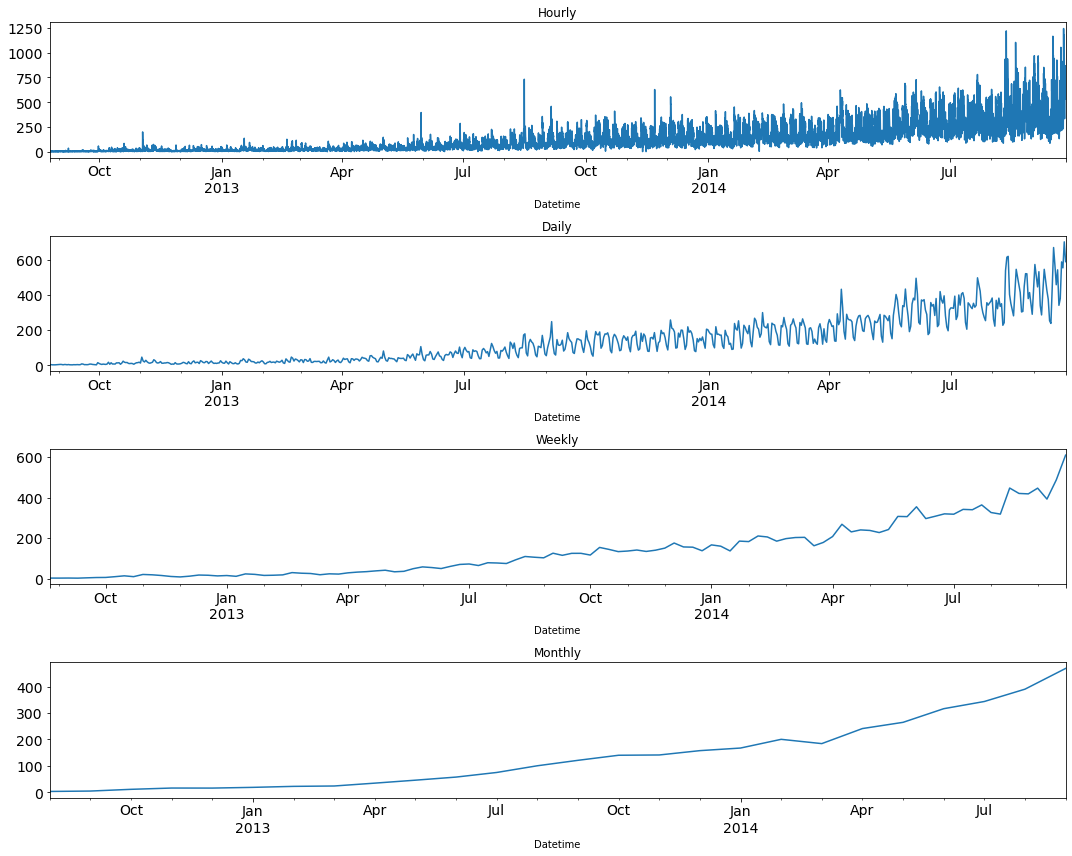

In [22]:
fig_length = 15
fig_height = 12

fig, axs = plt.subplots(4, 1) 
hourly.Count.plot(figsize=(fig_length, fig_height), title= 'Hourly', fontsize=14, ax=axs[0])
daily.Count.plot(figsize=(fig_length, fig_height), title= 'Daily', fontsize=14, ax=axs[1])
weekly.Count.plot(figsize=(fig_length, fig_height), title= 'Weekly', fontsize=14, ax=axs[2]) 
monthly.Count.plot(figsize=(fig_length, fig_height), title= 'Monthly', fontsize=14, ax=axs[3]) 

plt.tight_layout()
plt.show()

In [23]:
# Resample train data to daily
train.Timestamp = pd.to_datetime(train.Datetime,format='%d-%m-%Y %H:%M')
train.index = train.Timestamp  
train = train.resample('D').mean()

# Resample test data to daily
test.Timestamp = pd.to_datetime(test.Datetime,format='%d-%m-%Y %H:%M') 
test.index = test.Timestamp 
test = test.resample('D').mean() 

In [24]:
train.head()

,Count,year,month,day,hour,day of week,weekend
Datetime,,,,,,,
2012-08-25,3.166667,2012.0,8.0,25.0,11.5,5.0,1.0
2012-08-26,3.666667,2012.0,8.0,26.0,11.5,6.0,1.0
2012-08-27,2.583333,2012.0,8.0,27.0,11.5,0.0,0.0
2012-08-28,2.416667,2012.0,8.0,28.0,11.5,1.0,0.0
2012-08-29,2.500000,2012.0,8.0,29.0,11.5,2.0,0.0


In [25]:
test.head()

,year,month,day,hour,day of week
Datetime,,,,,
2014-09-26,2014.0,9.0,26.0,11.5,4.0
2014-09-27,2014.0,9.0,27.0,11.5,5.0
2014-09-28,2014.0,9.0,28.0,11.5,6.0
2014-09-29,2014.0,9.0,29.0,11.5,0.0
2014-09-30,2014.0,9.0,30.0,11.5,1.0


## Create validation dataset

* Split our training data into 2 parts: training and validation
* We train our model on the training portion
* We validate the model on the validation portion
* Original training data is from 25/08/2012 to 25/09/2014
* Split the data such that validation is the last 3 months, the rest is for training

In [26]:
print(f"Train first date: {train.index.min()}")
print(f"Train last date: {train.index.max()}")

Train first date: 2012-08-25 00:00:00
Train last date: 2014-09-25 00:00:00


In [27]:
start_train = '2012-08-25'
end_train = '2014-06-24'
start_validation = '2014-06-25'
end_validation = '2014-09-25'

valid = train.loc[start_validation: end_validation]
train = train.loc[start_train: end_train]

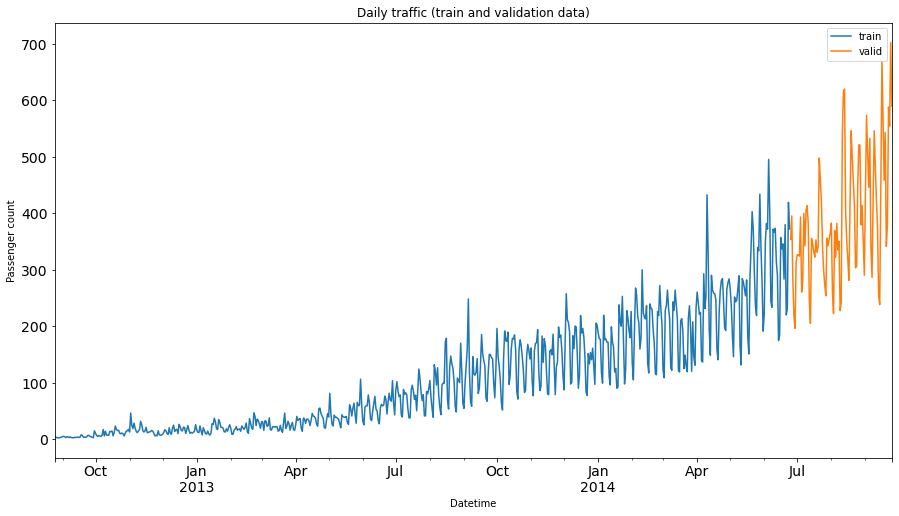

In [28]:
figsize = (15, 8)
title = 'Daily traffic (train and validation data)'

train.Count.plot(figsize=figsize, title=title, fontsize=14, label='train') 
valid.Count.plot(figsize=figsize, title=title, fontsize=14, label='valid') 
plt.xlabel("Datetime")
plt.ylabel("Passenger count") 
plt.legend(loc='best')
plt.show()

## Model building

Four models will be built:
1. Naive approach
2. Moving average
3. Simple exponential smoothing
4. Holt's linear trend

### 1. Naive approach

* The next expected point equals the last observed point
* Predictions are a horizontal line
* RMSE is 111.79 which is poor

In [29]:
last_value = train.Count.iloc[-1]

# y_hat are our Naive model predictions
y_hat = valid.copy() 
y_hat['naive'] = last_value

In [30]:
y_hat.tail()

,Count,year,month,day,hour,day of week,weekend,naive
Datetime,,,,,,,,
2014-09-21,379.250000,2014.0,9.0,21.0,11.5,6.0,1.0,372.166667
2014-09-22,588.166667,2014.0,9.0,22.0,11.5,0.0,0.0,372.166667
2014-09-23,554.333333,2014.0,9.0,23.0,11.5,1.0,0.0,372.166667
2014-09-24,702.333333,2014.0,9.0,24.0,11.5,2.0,0.0,372.166667
2014-09-25,589.666667,2014.0,9.0,25.0,11.5,3.0,0.0,372.166667


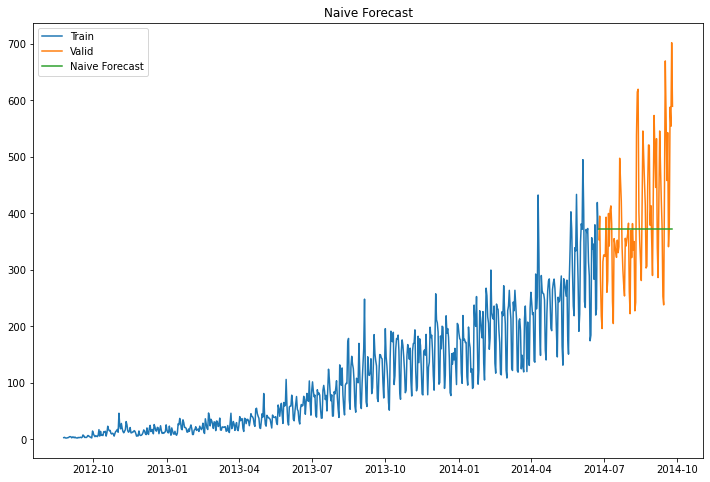

In [31]:
plt.figure(figsize=(12, 8)) 
plt.plot(train.index, train['Count'], label='Train') 
plt.plot(valid.index, valid['Count'], label='Valid') 
plt.plot(y_hat.index, y_hat['naive'], label='Naive Forecast') 
plt.legend(loc='best') 
plt.title("Naive Forecast") 
plt.show()

In [34]:
# Calculate Root Mean Square Error
rmse = sqrt(mean_squared_error(valid.Count, y_hat.naive)) 
print(f"Naive model RMSE = {rmse:.2f}")

Naive model RMSE = 111.79


### 2. Moving average

* Take the average of the passenger counts for the last few time periods only
* We take the rolling mean for the last 10, 20, and 50 days
* RMSE for the 10 day moving average is 134.24
* RMSE for the 20 day moving average is 130.45
* RMSE for the 50 day moving average is 144.19
* RMSE worsens as we increase the time window
* All RMSE are worse than the naive approach

Moving average (10 days) model RMSE = 134.24


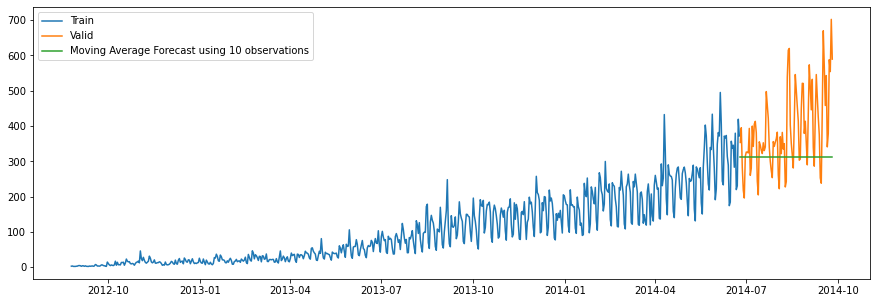

Moving average (20 days) model RMSE = 130.45


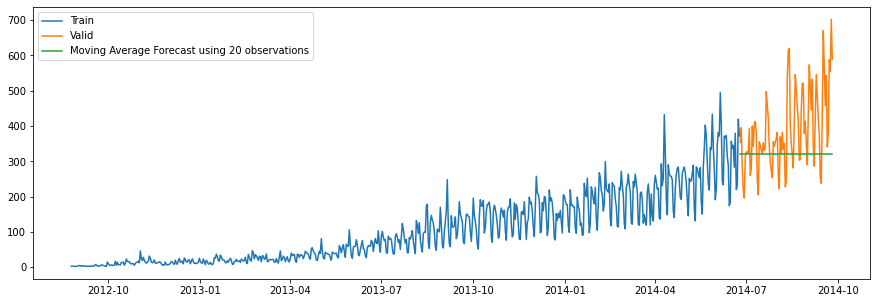

Moving average (50 days) model RMSE = 144.19


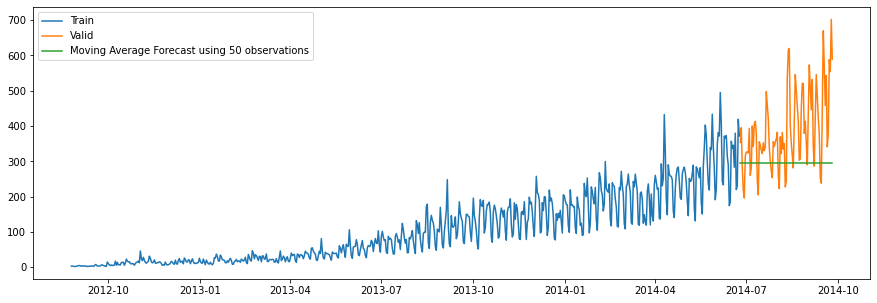

In [66]:
window_sizes = [10, 20, 50]
for window_size in window_sizes:
    y_hat_avg = calculate_moving_average(window_size=window_size)
    # Calculate Root Mean Square Error
    rmse = sqrt(mean_squared_error(valid.Count, y_hat_avg.moving_avg_forecast))
    print(f"Moving average ({window_size} days) model RMSE = {rmse:.2f}")
    plot_moving_average(y_hat_avg, window_size=window_size)


### 3. Simple exponential smoothing

* Assign larger weights to more recent observations
* Weights decrease exponentially as observations come from further in the past
* Smallest weights associated with the oldest observations
* The extreme case is to assign the entire weight to the last observed value only. This is equivalent to the naive approach
* RMSE is 113.44 which is poor

In [71]:
y_hat_avg = valid.copy()
fit2 = SimpleExpSmoothing(np.asarray(train['Count'])).fit(smoothing_level=0.6,
                                                          optimized=False)
y_hat_avg['SES'] = fit2.forecast(len(valid))


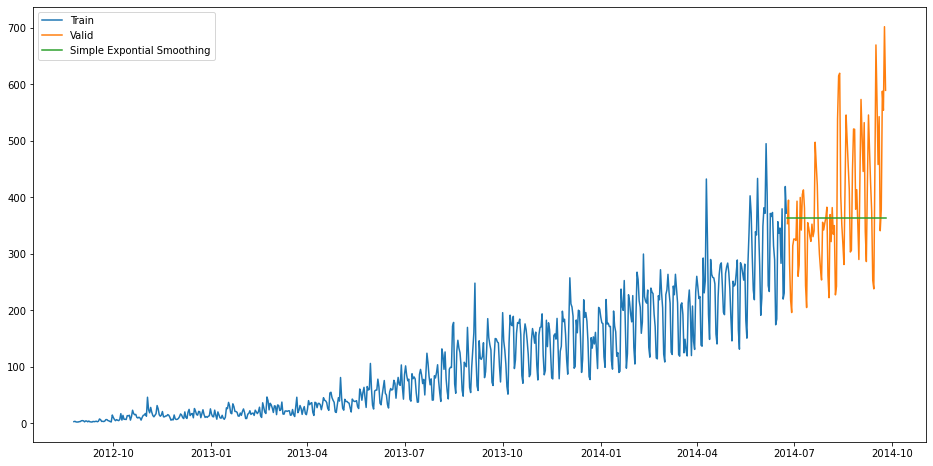

In [74]:
plt.figure(figsize=(16,8))  
plt.plot(train['Count'], label='Train') 
plt.plot(valid['Count'], label='Valid') 
plt.plot(y_hat_avg['SES'], label='Simple Expontial Smoothing') 
plt.legend(loc='best') 
plt.show()

In [75]:
rmse = sqrt(mean_squared_error(valid.Count, y_hat_avg.SES)) 
print(f"Simple exponential smoothing model RMSE = {rmse:.2f}")

Simple exponential smoothing model RMSE = 113.44


### 4. Holt's linear trend model

* Extension of simple exponential smoothing to allow forecasting of data with a trend
* Decompose the time series into 4 parts:
  * Observed. This is the original time series
  * Trend. Increasing or decreasing behaviour of the time series
  * Seasonal. Seasonality of the time series
  * Residual. Obtained by removing any trend or seasonality in the time series
* RMSE is 112.94 which is poor

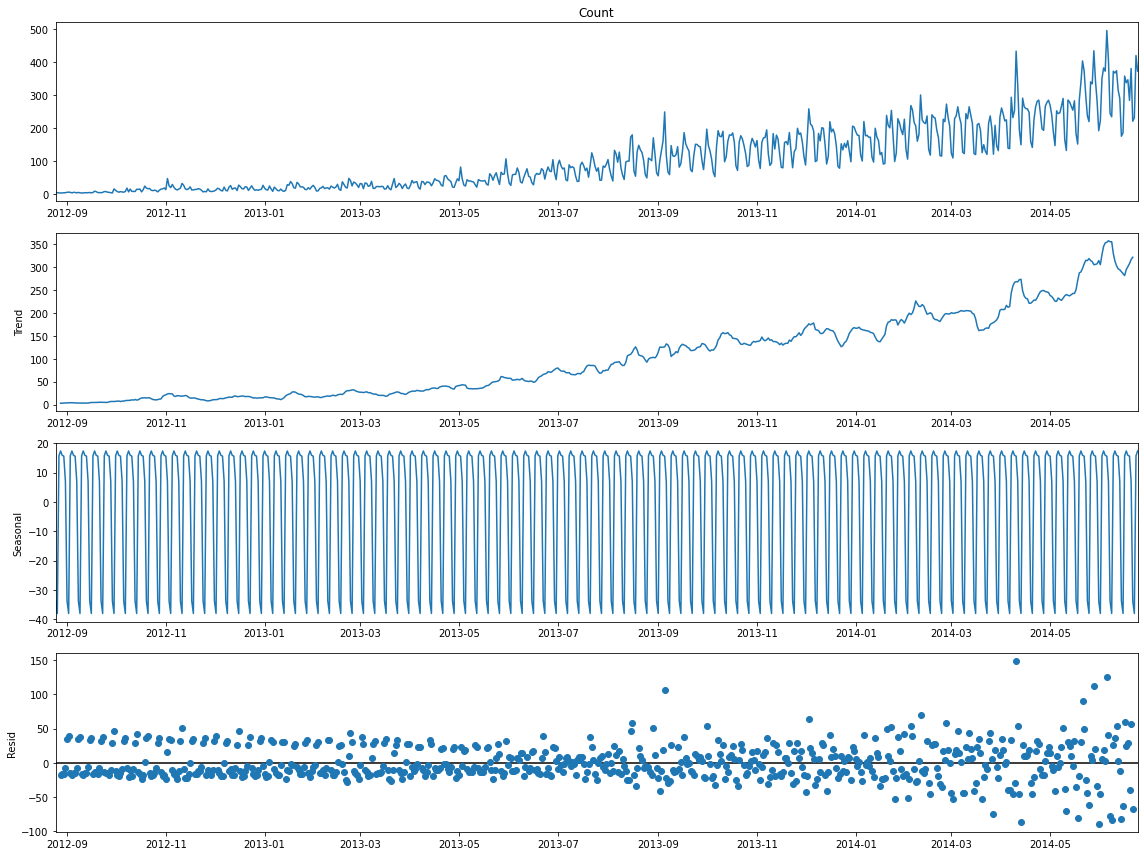

In [89]:
decomp_visual = sm.tsa.seasonal_decompose(train.Count)
fig = decomp_visual.plot()
fig.set_size_inches((16, 12))
fig.tight_layout()
result = sm.tsa.stattools.adfuller(train.Count)
plt.show() 

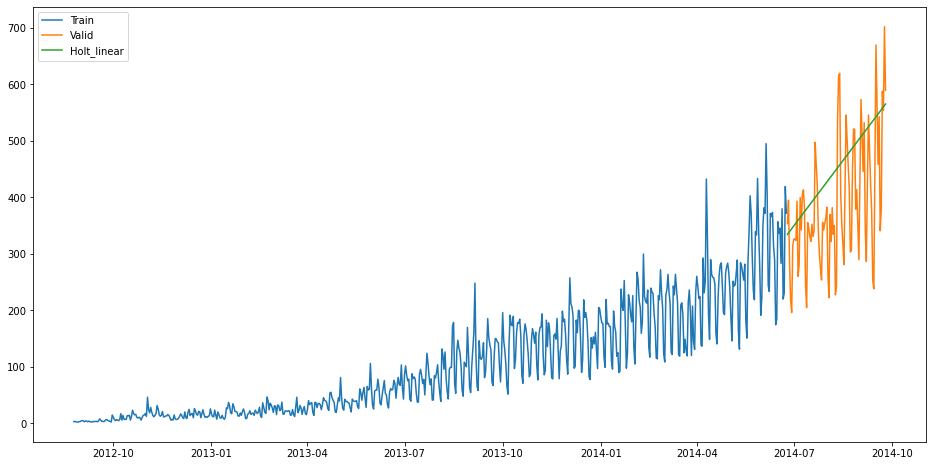

In [91]:
y_hat_avg = valid.copy() 
fit1 = Holt(np.asarray(train['Count'])).fit(smoothing_level=0.3,
        smoothing_slope = 0.1)
y_hat_avg['Holt_linear'] = fit1.forecast(len(valid)) 
plt.figure(figsize=(16,8))
plt.plot(train['Count'], label='Train')
plt.plot(valid['Count'], label='Valid') 
plt.plot(y_hat_avg['Holt_linear'], label='Holt_linear') 
plt.legend(loc='best') 
plt.show()

In [92]:
rmse = sqrt(mean_squared_error(valid.Count, y_hat_avg.Holt_linear)) 
print(f"Holt linear trend model RMSE = {rmse:.2f}")

Holt linear trend model RMSE = 112.94
